# Chunk Size vs. Execution Time

## Introduction
This experiment focuses on exploring the relationship between chunk size and the execution time of distributed computations in Dask.
In distributed systems like Dask, breaking large datasets into smaller chunks allows parallel computation across multiple workers.
However, determining the optimal chunk size can be a challenging task, as it directly affects both performance and resource utilization.

The goal of this experiment is to identify the chunk size that optimally balances task scheduling overhead and computation time to maximize performance.
By testing various chunk sizes, we aim to uncover patterns and insights that can guide best practices in chunking strategies for distributed computing.

## Problem Statement

Choosing the correct chunk size in distributed systems is crucial.
Too small a chunk size can result in excessive overhead from task scheduling and network communication, while too large a chunk size may overwhelm individual workers’ memory and processing capabilities.
This experiment seeks to determine the chunk size that provides the best performance by minimizing execution time while efficiently utilizing computational resources.

The main challenge lies in finding the balance between task scheduling overhead and the computation time of each chunk.
As datasets grow larger, this balance becomes increasingly important in optimizing distributed systems like Dask.

## Key Questions

**1. How does varying the chunk size influence execution time?**
In distributed computations, the chunk size determines how many tasks are created and how much data each worker processes at once.
A larger chunk size reduces the number of tasks but increases the workload per task. Conversely, smaller chunks create more tasks but reduce the per-task workload.
We will explore how changing the chunk size impacts overall execution time, looking for patterns in how the system reacts to different configurations.

**2. What is the relationship between chunk size, task scheduling overhead, and overall computation time?**
Chunking affects not only computation time but also task scheduling.
Task scheduling overhead refers to the time spent assigning tasks to workers, which grows with the number of tasks (i.e., smaller chunk sizes).
The experiment will investigate this relationship, quantifying how much time is spent on task scheduling versus actual computation. Understanding this relationship is critical in finding the right balance between chunk size and system performance.

## Methodology

To explore these questions, this experiment will use the following steps:

1. **Dataset Selection**:
A large seismic dataset will be synthetically generated as the test subject. The dataset will be large enough to stress the system and highlight the performance impact of different chunk sizes.

2. **Algorithm Selection**:
The experiment will utilize a tensorial algorithm commonly used in seismic data processing.
The choice of algorithm is important because different algorithms may have varying sensitivities to chunk size and memory usage, which could affect the execution time and resource utilization.
By focusing on specific algorithms, we will be able to measure chunking performance in a real-world scenario.

4. **Varying Chunk Sizes**:
We will manually set different chunk sizes and observe their impact on execution time. This will include both very small and very large chunk sizes to capture the full spectrum of performance behavior.

5. **Task Scheduling Overhead Analysis**:
For each chunk size, we will measure the task scheduling overhead separately from the computation time. This will help quantify the relationship between task scheduling and execution time.

6. **Performance Tracking**:
Execution time will be tracked and logged for each experiment. In addition, memory usage and CPU utilization will be monitored to ensure that resource constraints (e.g., memory saturation) do not bias the results.

7. **Results Comparison**:
Once the experiments are complete, we will analyze the results to find the optimal chunk size that balances execution time and resource utilization. A comparison will be made across different chunk sizes to identify patterns and trade-offs.

This methodology will provide insights into how chunk sizes affect performance and help identify strategies to optimize chunking for future distributed computations.

## Experiment Execution

Before starting the experiment, we need to set up the environment to ensure all steps run smoothly. It is assumed that you have already installed all the required dependencies from the root requirements.txt file located at `../requirements.txt`.

In [1]:
import sys


def link_libs_to_path():
    libs_path = os.path.abspath('../libs')
    if libs_path not in sys.path:
        sys.path.append(libs_path)

    are_libs_in_sys_path = libs_path in sys.path
    print(f"Are libs properly linked to your sys.path? -> {'Yes' if are_libs_in_sys_path else 'No'}")


link_libs_to_path()

Are libs properly linked to your sys.path? -> Yes


### Dataset Selection

In this experiment, we will generate a synthetic seismic cube to serve as our dataset.
Seismic cubes are typically large, multi-dimensional arrays, making them ideal for testing distributed computation and chunking strategies.

To generate the dataset, we will utilize utility libraries that have already been linked to your sys.path during the environment setup.
These libraries provide convenient functions for creating large datasets with configurable shapes, allowing you to adjust the size of the cube according to your machine’s available memory.

You can modify the cube’s shape in the initial parameters of the notebook.
We recommend setting the dimensions of the seismic cube based on the memory capacity of your machine to prevent memory overload and ensure smooth execution of the experiment.
If you are unsure, start with smaller sizes and gradually increase them to explore the impact on execution time and performance.

2024-10-23 20:32:03 - dataset-selection - INFO - Generating seismic data with dimensions: NUM_INLINES=300, NUM_XLINES=300, NUM_SAMPLES=300
2024-10-23 20:32:03 - dataset-selection - INFO - Output will be saved to ./outputs/001-20241023203203
2024-10-23 20:32:03 - generate-seismic-data - INFO - Generating synthetic data for shape (300, 300, 300)
2024-10-23 20:32:08 - dataset-selection - INFO - Seismic data generation completed. Data saved to ./outputs/001-20241023203203/data/300-300-300.segy


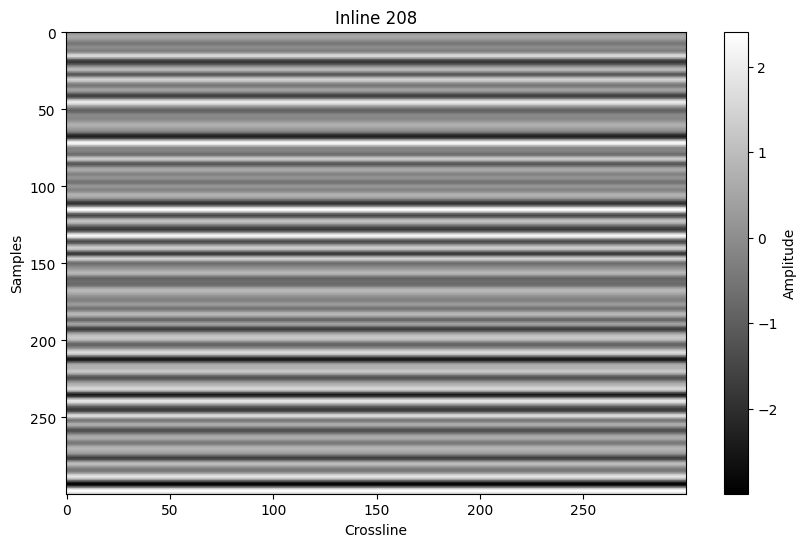

In [2]:
import os

from utils import generate_output_dir_path
from datasets import generate_seismic_data, load_segy, render_random_inline
from loggers import get_named_logger

logger = get_named_logger('dataset-selection')

NUM_INLINES = 300
NUM_XLINES = 300
NUM_SAMPLES = 300

OUTPUT_DIR = generate_output_dir_path('001')
DATA_DIR = os.path.join(OUTPUT_DIR, 'experiment')

logger.info(
    f"Generating seismic experiment with dimensions: "
    f"NUM_INLINES={NUM_INLINES}, NUM_XLINES={NUM_XLINES}, NUM_SAMPLES={NUM_SAMPLES}")
logger.info(f"Output will be saved to {OUTPUT_DIR}")

seismic_data_path = generate_seismic_data(
    NUM_INLINES,
    NUM_XLINES,
    NUM_SAMPLES,
    output_dir=DATA_DIR,
)

logger.info(f"Seismic experiment generation completed. Data saved to {seismic_data_path}")

seismic_data = load_segy(seismic_data_path)
render_random_inline(seismic_data)

### Algorithm Selection

In this experiment, we will test the impact of chunk sizes on the execution of several algorithms, focusing on both seismic-specific and general-purpose computations.
These algorithms will help us understand how chunk size affects different types of computational workloads, from simpler to more complex tasks.
The selected algorithms include:

- **Envelope**:
The envelope algorithm is widely used in seismic processing to extract the instantaneous amplitude of a seismic signal.
It is computationally lightweight and generally does not require significant memory resources.
This makes it an ideal candidate for testing chunk size behavior under less memory-intensive conditions, allowing us to observe how Dask’s chunking strategies perform with lower memory consumption.

- **GST3D (Generalized S-transform in 3D)**:
GST3D is a time-frequency analysis algorithm applied to 3D seismic data.
Unlike the envelope algorithm, GST3D is computationally heavy and memory-intensive.
It requires multiple transformations and matrix operations across the entire seismic cube, which quickly consumes memory, especially as the data size grows.
This algorithm will help us stress-test chunking performance under memory-constrained conditions, providing valuable insights into how Dask handles chunking for complex seismic computations.

- **3D Gaussian Filtering**:
To include a non-seismic algorithm that can still process 3D data like a seismic cube, we suggest 3D Gaussian Filtering.
This is a standard algorithm used in image and signal processing for smoothing data and reducing noise.
The algorithm performs convolution over the 3D array (the seismic cube), making it computationally relevant to chunking strategies in a distributed setting.
It is not as memory-intensive as GST3D but still requires substantial computation, making it an excellent candidate for exploring how chunk size impacts non-seismic algorithms.

By testing these three algorithms: one lightweight (Envelope), one heavy (GST3D), and one general-purpose (3D Gaussian Filtering), we can evaluate how chunk size affects performance in both simple and complex computational contexts.
The goal is to find chunking strategies that strike the best balance between execution time and memory usage, based on the complexity of the algorithm and the data size.

In [3]:
from operators import envelope_from_segy, gradient_structure_tensor_from_segy, gaussian_filter_from_segy
from loggers import get_named_logger

logger = get_named_logger('algorithm-selection')

apply_envelope = envelope_from_segy
apply_gst3d = gradient_structure_tensor_from_segy
apply_gaussian_filter = gaussian_filter_from_segy

logger.info(f'Envelope using {apply_envelope}')
logger.info(f'GST3D using {apply_gst3d}')
logger.info(f'3D Gaussian Filter using {apply_gaussian_filter}')

2024-10-23 20:32:08 - algorithm-selection - INFO - Envelope using <function envelope_from_segy at 0x7fe38503e8c0>
2024-10-23 20:32:08 - algorithm-selection - INFO - GST3D using <function gradient_structure_tensor_from_segy at 0x7fe384e38550>
2024-10-23 20:32:08 - algorithm-selection - INFO - 3D Gaussian Filter using <function gaussian_filter_from_segy at 0x7fe384e38430>


### Collecting Data

Now that the seismic data has been generated and the algorithms have been selected, the next step involves preparing the data for the experiment.
Here’s how we’ll proceed with collecting and organizing the necessary data for analysis:

1. **Chunk Size Configuration**:
We will begin by manually configuring different chunk sizes.
These chunk sizes will range from very small to large, allowing us to observe the full impact on execution time and resource usage.
Each chunk size will be applied to the same synthetic seismic dataset to ensure consistent comparison.

2. **Running the Algorithms**:
For each configured chunk size, the selected algorithms (Envelope, GST3D, and 3D Gaussian Filtering) will be applied to the seismic dataset.
Each algorithm will be executed across multiple chunk size configurations, and the performance metrics will be recorded.

3. **Task Scheduling and Execution Time Data**:
During the execution of each algorithm, we will collect detailed performance data:
    - Execution Time: The total time taken to process the seismic data for each algorithm using the specified chunk size. This includes both computation time and task scheduling time.
    - Task Scheduling Overhead: Dask’s task scheduling overhead will be monitored separately to understand the impact of chunk size on the overhead. This data will help isolate the time spent on scheduling tasks versus the time spent on computation.
    - Memory Usage and CPU Utilization: Memory consumption and CPU usage will be tracked for each run. These metrics are critical to understanding how chunk size affects system resource allocation and will help identify any memory or CPU bottlenecks.

4. **Logging and Storing the Results**:
The collected data will be logged for each chunk size configuration.
This will include the execution time, task scheduling overhead, memory usage, and CPU utilization for all algorithms. The results will be stored in a structured format for later analysis.

By collecting this data across a range of chunk sizes, we will be able to visualize the relationship between chunk size, task scheduling overhead, and execution time.
This will allow us to identify the optimal chunk size that balances performance and resource usage, ultimately guiding best practices in distributed chunking strategies for future computations.

#### Experiment Metrics

To comprehensively evaluate the performance of various chunking strategies in distributed Dask computations, we will track the following key metrics, denoted by variables:

1. **Number of Chunks ($c$)**:
The number of chunks refers to the total number of data chunks into which the dataset is divided for parallel processing.
It represents how the dataset is split to allow distribution across multiple workers in a distributed system like Dask.
It is expressed as: $c = \frac{\text{total\_dataset\_size}}{\text{chunk\_size}}$

    - Lower values of $c$ (i.e., fewer chunks) mean that fewer, larger chunks are processed by workers, leading to more intensive workloads per chunk and potentially less parallelism.
    - Higher values of $c$ (i.e., more chunks) indicate finer granularity of the workload, allowing more tasks to be distributed across workers. However, this can lead to increased task scheduling overhead, as the system needs to manage more tasks.

2. **Chunk-to-Worker Ratio ($r$)**:
This metric defines the relationship between the number of chunks ($c$) and the number of workers ($w$) available in the system.
It is expressed as: $r = \frac{c}{w}$

    - A ratio of $r = 1$ indicates a balanced system where each worker handles exactly one chunk.
    - If $r < 1$, there are fewer chunks than workers, potentially leading to underutilization of resources.
    - If $r > 1$, more chunks than workers are created, resulting in multiple tasks per worker and potentially increasing scheduling overhead.

3. **Relative Chunk Size ($s$)**:
The relative chunk size measures how large each chunk is in relation to the total volume of the dataset, reflecting the proportion of the dataset handled by each chunk.
It is expressed as: $s = \frac{\text{chunk\_volume}}{\text{dataset\_volume}}$.
Where the volume of a chunk can be represented as the product of the dimensions of the chunk (e.g., $v_{\text{chunk}} = n_{\text{inline}} \times n_{\text{xline}} \times n_{\text{samples}}$).

    - Smaller values of $s$ indicate that each chunk represents a smaller fraction of the dataset’s total volume, promoting higher levels of parallelism but potentially increasing task scheduling overhead.
    - Larger values of $s$ suggest that each chunk encompasses a significant portion of the dataset’s volume, resulting in fewer tasks that are heavier and may consume more memory and resources per worker.

4. **Execution Time ($T$)**:
This is the total time taken to complete the computation, including both task scheduling and actual processing time.
It is the primary performance metric to assess how efficiently Dask handles different chunking configurations. Minimizing $T$ is the goal, as shorter execution times indicate better performance.

5. **Task Scheduling Overhead ($O_{\text{sched}}$)**:
The time Dask spends scheduling tasks across workers.
This overhead becomes significant when using many small chunks, as each chunk incurs scheduling costs.
It is defined as the portion of the total execution time spent on task management rather than computation.

6. **Memory Usage ($M_{\text{peak}}$)**:
This metric tracks the peak memory usage across workers during the computation.
It is critical to monitor memory usage because larger chunks can lead to excessive memory consumption, causing performance degradation or worker crashes if memory limits are exceeded.
Memory usage will be influenced by chunk size, and monitoring it ensures that the chunking strategy is optimized for both time and resource constraints.

These metrics ($r$, $s$, $T$, $O_{\text{sched}}$, and $M_{\text{peak}}$) will provide a clear and comprehensive understanding of how different chunking configurations affect the performance and resource utilization of distributed computations.

#### Experiment Setup

In this experiment, we will test the impact of varying the number of chunks relative to the number of workers available in a distributed Dask environment.
The goal is to explore how the relationship between chunk size and the number of workers affects overall performance and resource utilization.

We will investigate several key scenarios:

1. **Single Chunk (Monolithic Chunking, $c = 1$)**:
In this scenario, the entire dataset will be processed as a single chunk.
This disables parallelism since only one worker can process the task. The chunk-to-worker ratio ($r$) is $1$ if there is one worker, and the relative chunk size ($s$) will be $1$.
This test helps assess memory usage ($m_{\text{usage}}$) and system behavior under minimal parallelism.

2. **Few Chunks (Minimal Chunking, $c \approx 1$)**:
This scenario tests configurations where the number of chunks is slightly greater than $1$ but still far fewer than the available workers.
The chunk-to-worker ratio ($r$) will still be close to $1$, and the relative chunk size ($s$) will be large, meaning each chunk represents a significant portion of the dataset.
This helps explore how Dask handles moderate parallelism and the impact on execution time ($t_{\text{exec}}$) and memory usage.

3. **Chunks Less Than Workers ($c < w$)**:
Here, the number of chunks is less than the available workers, resulting in idle workers and underutilization of resources.
This scenario tests how Dask performs when some workers are not assigned tasks.
The chunk-to-worker ratio ($r$) will be less than $1$, and the relative chunk size ($s$) will be larger, representing fewer but heavier tasks per worker.

4. **Chunks Equal to Workers ($c = w$)**:
In this balanced scenario, the number of chunks matches the number of workers, creating an ideal situation where every worker has exactly one task.
The chunk-to-worker ratio ($r$) is $1$, and the relative chunk size ($s$) is moderate.
This allows us to observe the effects of perfectly balanced workload distribution on execution time ($t_{\text{exec}}$) and scheduling overhead ($t_{\text{sched}}$).

5. **Chunks Greater Than Workers ($c > w$)**:
In this case, more chunks than workers are created, requiring workers to process multiple tasks.
This configuration increases parallelism but may introduce higher task scheduling overhead ($t_{\text{sched}}$) as more tasks are queued.
The chunk-to-worker ratio ($r$) will be greater than $1$, while the relative chunk size ($s$) will be smaller, representing smaller, more numerous tasks per worker.

By testing these configurations and observing the key metrics ($r$, $s$, $T$, $O_{\text{sched}}$, and $M_{\text{peak}}$), we aim to gain deeper insights into how chunk size impacts performance across various distributed environments.
This will offer valuable guidelines for fine-tuning chunking strategies to make better use of system resources based on capabilities.

In [4]:
experiments = {
    # 1 chunk for 1 worker (c = 1, r = 1, s = 1)
    "a": (1, 1),

    # 1 chunk for 3 workers (c = 1, r = 0.33, s = 1)
    "b": (1, 3),

    # 2 chunks for 5 workers (c ~ 1, r = 0.4, s = 0.125)
    "c": (2, 5),

    # 4 chunks for 5 workers (c ~ 1, r = 0.8, s = 0.015)
    "d": (4, 5),

    # 5 chunks for 10 workers (c < w, r = 0.5, s = 0.008)
    #"e": (5, 10),  

    # 10 chunks for 5 workers (c > w, r = 2, s = 0.001)
    "f": (10, 5),

    # 50 chunks for 5 workers (c > w, r = 10, s = 0.000008)
    "g": (50, 5),

    # 100 chunks for 10 workers (c > w, r = 10, s = 0.000001)
    "h": (100, 10),

    # 10 chunks for 10 workers (c = w, r = 1, s = 0.001)
    "i": (10, 10),
}

#### Experiment Execution

In this section, we will test different configurations of chunks and workers to analyze their impact on distributed performance in Dask.
The following procedure will be followed for each experiment iteration:

1. Experiment Selection:
We will select the next experiment configuration from the predefined set of experiments.
Each configuration consists of a combination of the number of chunks ($c$) and the number of workers ($w$).

2. Dask Cluster Setup:
For each experiment, we will create a new Dask cluster with the specified number of workers ($w$).
The cluster will manage task distribution and execution across the workers.

3. Dask Array Chunking:
We will create a Dask array representing the seismic cube and apply the specified chunking strategy based on the current experiment configuration.
This array will be divided into $c$ chunks.

4. Algorithm Execution:
We will run the selected algorithms on the chunked Dask array:
    - Envelope algorithm
	- GST3D (Generalized S-transform in 3D)
	- 3D Gaussian filtering.

5. Metrics Collection:
During the execution, we will collect the following metrics:
	- Execution Time ($T$): Total time taken for the computation.
	- Task Scheduling Overhead ($O_{sched}$): Time spent on scheduling tasks by Dask.
	- Memory Usage ($M_{peak}$): Peak memory usage during the execution.

6. Repeat:
We will iterate through the entire set of experiments, adjusting chunk sizes and worker counts, and repeating the process until all configurations have been tested.

By the end of the experiment, we will have a dataset of performance metrics for each configuration.
These results will help us analyze the relationship between chunk size, execution time, task scheduling overhead, and memory usage, providing insights into optimal chunking strategies in distributed systems like Dask.

In [5]:
import pandas as pd

df_columns = [
    'n_inlines',
    'n_xlines',
    'n_samples',
    'experiment_name',
    'c',
    'w',
    'r',
    's',
    'algorithm',
    'T',
    'O_sched',
    'M_peak',
]
df_results = pd.DataFrame(columns=df_columns)
enabled_algorithms = [apply_envelope, apply_gst3d, apply_gaussian_filter]

To avoid Dask stacking unhandled memory and adding biases to the results, we need to scope each experiment iteration within a separate process that we can completely close before starting the next one.

In [6]:
def run_scoped_experiment(pipe, algorithm, segy_path, c, w, experiment_name, memory_limit, num_inlines, num_xlines,
                          num_samples):
    import sys
    import io
    import time

    from dask.distributed import Client, LocalCluster
    from dask.utils import format_time, format_bytes

    sys.path.append('../libs')

    from utils import get_worker_peak_memory, OverheadPlugin

    old_stdout = sys.stdout
    sys.stdout = mystdout = io.StringIO()

    with LocalCluster(
            n_workers=w,
            memory_limit=f'{memory_limit / w}GB',
    ) as cluster:
        with Client(cluster) as client:
            overhead_plugin = OverheadPlugin()
            cluster.scheduler.add_plugin(overhead_plugin)

            start_time = time.perf_counter()
            task = algorithm(seismic_data_path, chunks=(num_inlines / c, num_xlines / c, num_samples / c))
            task.compute()
            end_time = time.perf_counter()

            execution_time = end_time - start_time
            print(f"Total Execution Time: {execution_time:.2f} seconds")

            peak_memory = client.run(get_worker_peak_memory)

            avg_peak_memory = sum(peak_memory.values()) / len(peak_memory.values())
            print(f"Average Peak Memory Usage: {avg_peak_memory}")

            max_peak_memory = max(peak_memory.values())
            print(f"Max Peak Memory Usage: {max_peak_memory}")
            print("Peak Memory Usage per Worker:")
            for worker, mem_bytes in peak_memory.items():
                print(f"{worker}: {format_bytes(mem_bytes)}")

            total_overhead, max_overhead, avg_overhead = overhead_plugin.get_overhead_stats()
            print(f"\nTotal Scheduling Overhead (sum of all task overheads): {format_time(total_overhead)}")
            print(f"Maximum Scheduling Overhead per Task: {format_time(max_overhead)}")
            print(f"Average Scheduling Overhead per Task: {format_time(avg_overhead)}")

            experiment_result = {
                'n_inlines': num_inlines,
                'n_xlines': num_xlines,
                'n_samples': num_samples,
                'experiment_name': experiment_name,
                'c': c,
                'w': w,
                'r': c / w,
                's': (num_inlines / c * num_xlines / c * num_samples / c) / (num_inlines * num_xlines * num_samples),
                'algorithm': algorithm.__name__,
                'T': execution_time,
                'O_sched': max_overhead,
                'M_peak': max_peak_memory,
            }

            sys.stdout = old_stdout

            result = {
                'logs': mystdout.getvalue(),
                'experiment': experiment_result,
            }

            pipe.send(result)
            pipe.close()

In [ ]:
import multiprocessing

from loggers import get_named_logger

MEMORY_LIMIT = 24  # In GB
RESULT_FILE = f'{OUTPUT_DIR}/results.pkl'

logger = get_named_logger('experiment-execution')

for experiment_name, (num_chunks, num_workers) in experiments.items():
    for algorithm in enabled_algorithms:
        logger.info(
            f'Starting \033[43mexperiment "{experiment_name.upper()}"\033[0m for {algorithm.__name__} with {num_chunks} chunks and {num_workers} workers')

        parent_conn, child_conn = multiprocessing.Pipe()
        p = multiprocessing.Process(
            target=run_scoped_experiment,
            args=(
                child_conn,
                algorithm,
                seismic_data_path,
                num_chunks,
                num_workers,
                experiment_name,
                MEMORY_LIMIT,
                NUM_INLINES,
                NUM_XLINES,
                NUM_SAMPLES,
            )
        )
        p.start()
        p.join()
        result = parent_conn.recv()
        experiment_result = result['experiment']

        logger.info("Output from the subprocess logs:\n" + result['logs'])

        df_results = pd.concat([df_results, pd.DataFrame([experiment_result])], ignore_index=True)
        df_results.to_pickle(RESULT_FILE)

        logger.info(
            f'Finished experiment "{experiment_name.upper()}" for {algorithm.__name__} with {num_chunks} chunks and {num_workers} workers')

with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(df_results)

2024-10-23 20:32:08 - experiment-execution - INFO - Starting experiment "A" for envelope_from_segy with 1 chunks and 1 workers
2024-10-23 20:32:09 - envelope - INFO - Calculating envelope for ./outputs/001-20241023203203/data/300-300-300.segy
2024-10-23 20:32:09 - envelope - INFO - Data shape: (300, 300, 300)
2024-10-23 20:32:09 - envelope - INFO - Data chunks: ((300,), (300,), (300,))
/home/delucca/.pyenv/versions/3.10.14/envs/dask-auto-chunking/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 103.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2024-10-23 20:32:10 - experiment-execution - INFO - Output from the subprocess logs:
Total Execution Time: 0.89 seconds
Average Peak Memory Usage: 8992563

In [2]:
import pandas as pd

df = pd.read_pickle('./outputs/001-20241023203203/results.pkl')
display(df)

,n_inlines,n_xlines,n_samples,experiment_name,c,w,r,s,algorithm,T,O_sched,M_peak
0,300,300,300,a,1,1,1.000000,1.000000,envelope_from_segy,0.885155,0.031385,899256320
1,300,300,300,a,1,1,1.000000,1.000000,gradient_structure_tensor_from_segy,14.826689,0.883056,6983561216
2,300,300,300,a,1,1,1.000000,1.000000,gaussian_filter_from_segy,0.985606,0.021127,330276864
3,300,300,300,b,1,3,0.333333,1.000000,envelope_from_segy,0.864921,0.022748,900907008
4,300,300,300,b,1,3,0.333333,1.000000,gradient_structure_tensor_from_segy,14.892932,0.933269,6977904640
5,300,300,300,b,1,3,0.333333,1.000000,gaussian_filter_from_segy,1.039439,0.021136,330285056
6,300,300,300,c,2,5,0.400000,0.125000,envelope_from_segy,0.935808,0.062960,336445440
7,300,300,300,c,2,5,0.400000,0.125000,gradient_structure_tensor_from_segy,5.710416,1.909975,1841500160
8,300,300,300,c,2,5,0.400000,0.125000,gaussian_filter_from_segy,0.794163,0.161645,294944768
9,300,300,300,d,4,5,0.800000,0.015625,envelope_from_segy,1.065954,0.461830,294940672
